# Load and prepare Data

Initially, we import the gold standard into a dataframe and seperate the annotations provided by human annotators from the potenitally antisemetic tweets. The tweets will undergo annotation by the LLM later in our experiment, while the human annotations will provide the benchmark against which the LLM's annotations will be evaluated.

In [9]:
import pandas as pd
path = "../input/data/Updated_dataset_with_full_text/Updated_dataset_with_full_text.csv"
df = pd.read_csv(path)

,TweetID,Username,CreateDate,Biased,Keyword,Text
0,1232258532273090560,amit2nirvana,2020-02-25 10:58:23+00:00,0,Israel,The last 24 hours in Israel: https://t.co/0YNw...
1,1224025761092448257,NinjaAlex420,2020-02-02 17:44:17+00:00,0,Israel,@stranahan KnowMoreNews isn't confident enough...
2,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: f..."
3,1224677205306818561,MGSheikh8,2020-02-04 12:52:53+00:00,0,Israel,Opinion: No One in Israel Knew They Were Commi...
4,1214278369338109953,elianebis1,2020-01-06 20:11:38+00:00,0,Israel,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...
...,...,...,...,...,...,...
6936,1255850426899013632,TAG73957257,2020-04-30 13:24:09+00:00,1,ZioNazi,@JackieKane I'd never go back. ZioNazi managem...
6937,1234276923213303812,totalsatire,2020-03-02 00:38:44+00:00,1,ZioNazi,@JulianRoepcke The lovely Zionazi Djihad Julia...
6938,1240883925096030208,Futatimbo,2020-03-20 06:12:36+00:00,1,ZioNazi,@IvankaTrump A zionazists Jews.
6939,1241091821645844480,Futatimbo,2020-03-20 19:58:43+00:00,1,ZioNazi,"Mr. President, I this year you will lead the I..."


In [10]:
import re

filtered_df = df[~df["Text"].str.contains(r'https?://\S+', case=False, regex=True)]

print(df.shape)
print(filtered_df.shape)

# Resetting the indices
filtered_df = filtered_df.reset_index(drop=True)

filtered_df["Keyword"].value_counts(normalize=True)

(6941, 6)
(3235, 6)


Jews       0.691808
Israel     0.187326
ZioNazi    0.076352
Kikes      0.044513
Name: Keyword, dtype: float64

## Annotate Data

In [11]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chat_models import ChatOllama

#https://anakin.ai/blog/dolphin-2-5-mixtral-8x7b-uncensored-mistral/
chat_model = ChatOllama(
    model="dolphin-mistral", 
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
)

In [12]:
from langchain.schema import HumanMessage

messages = [HumanMessage(content="How are you")]
response = chat_model(messages)

Hi! I'm Dolphin, an artificial intelligence trained to assist and chat with users. I'm always happy to help and answer any questions or provide information you may need! Let me know if there's something specific I can do for you!

In [13]:
prompt_path = '../input/prompts/prompt_5.txt'

with open(prompt_path, 'r') as file:
    prompt = file.read()

prompt = prompt.replace('\n', ' ')
prompt

"<|im_start|>system You are Dolphin, an expert on Antisemitism working as a Tweet-Annotator, tasked with checking if tweets are antisemitic or not. You use the following definition of antisemitism: Antisemitism is a certain perception of Jews, which may be expressed as hatred toward Jews. Rhetorical and physical manifestations of antisemitism are directed toward Jewish or non-Jewish individuals or their property, toward Jewish community institutions and religious facilities. Antisemitism might include the targeting of the state of Israel, conceived as a Jewish collectivity. However, criticism of Israel similar to that leveled against any other country cannot be regarded as antisemitic. Antisemitism frequently charges Jews with conspiring to harm humanity, and it is often used to blame Jews for “why things go wrong.” Contemporary examples of antisemitism include: 1. Calling for or justifying the harming of Jews. 2. Making dehumanizing, demonizing, or stereotypical allegations about Jews

In [14]:
import numpy as np

# add predictions column if it doesn't exist
if "Predictions" not in filtered_df.columns:
    filtered_df["Prediction"] = np.nan

for index, row in filtered_df.iterrows():
    print(f"Row {index}:", end=" ")
    
    if pd.isna(row["Prediction"]):
        messages = [HumanMessage(content= prompt + row["Text"] + " <|im_end|><|im_start|>assistant")]
        answer = str(chat_model(messages))
        filtered_df.at[index, "Prediction"] = answer
        print("")
        
    else:
        print("Row skipped")

Row 0: 0. The tweet provided does not contain any content that falls under the definition of antisemitism provided. It is a quote from the Bible, referencing God's mercy for Israel as his servant and using relevant hashtags (#Bible #Poetry #God). It does not express hatred towards Jews or target Jewish individuals or institutions, nor does it use classic antisemitic tropes or apply double standards to Israel.
Row 1: 1) This tweet can be considered antisemitic according to the provided definition. The tweet contains several elements that fall under the categories of antisemitism, such as denying Jewish people's right to self-determination (by implying that Israel's existence is a racist endeavor), applying double standards to Israel (comparing it to Poland without context), and making stereotypical allegations about Jews or the power of Jews as a collective. By saying "Israel has been destroying Palestinians and stealing their land for DECADES," the tweet also targets the state of Israe

In [15]:
filtered_df[:30]

,TweetID,Username,CreateDate,Biased,Keyword,Text,Prediction
0,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: f...","content=""0. The tweet provided does not contai..."
1,1222609422238617600,Jan_lindsay,2020-01-29 19:56:15+00:00,1,Israel,@JoAnn54819331 @JB62154 @SexCounseling @Robert...,content='1) This tweet can be considered antis...
2,1217912306480316416,nickforthemany,2020-01-16 20:51:36+00:00,0,Israel,@Rachael_Swindon @knightrgb I agree however th...,content='0: This tweet does not directly or in...
3,1221102213797498882,BPost222,2020-01-25 16:07:09+00:00,0,Israel,🇮🇱 Israel Gym 🇮🇱 \n\n✨ Latias ✨\n\nGym : Don Q...,content='0\nThe tweet provided does not contai...
4,1213188309155008513,LadyLiberty1791,2020-01-03 20:00:07+00:00,0,Israel,Iran lied to America and the west\n\nIran fund...,"content=""0. This tweet does not directly conta..."
5,1234727115041517569,dbochemwlf,2020-03-03 06:27:39+00:00,0,Israel,@mrbesseder @BDS_Australia Hey hey bibi win......,content='0\n\nThis tweet does not fall under a...
6,1216390039065780225,MikeReeseM,2020-01-12 16:02:39+00:00,0,Israel,From India to Hungary to the US . . . Israel f...,"content=""0) The provided tweet does not meet t..."
7,1246436250770386945,capybaratime,2020-04-04 13:55:34+00:00,0,Israel,@mutedlavender ISabelle\nISrael\nreally makes ...,content='0\n\nThe provided tweet does not cont...
8,1233523876606468099,rockapepolitics,2020-02-28 22:46:24+00:00,0,Israel,The boycott movement (#BDS) against Israel is ...,content='1. This tweet could potentially be pe...
9,1229064832747483137,TunjiGbadamosi,2020-02-16 15:27:45+00:00,0,Israel,You don't get to label anyone critical of Isra...,content='0.\n\nThis tweet does not directly or...


In [3]:
from pathlib import Path  
filepath = Path("../output/annotations/experiment_mistral_prompt_5_exp.csv")

"""
# Save annotations to csv
filepath = Path("../output/annotations/experiment_mistral_prompt_5_exp.csv")
filtered_df.to_csv(filepath)
"""

'\n# Save annotations to csv\nfilepath = Path("../output/annotations/experiment_mistral_prompt_5_exp.csv")\nfiltered_df.to_csv(filepath)\n'

# Data Cleaning

As the model did not adhere to the specified answer-format, its predictions need to be converted to booleans. 


In [4]:
import pandas as pd
df = pd.read_csv(filepath)

As we can see, there are most of the answers are actually correctly formatted as booleans, while lots of others are variations of the same sentences. Accordingly, we should be able to standartize the models output manually. To do so, let's:
- remove prefixes "content=" and "[INST]"
- convert text to lowercase
- remove punctuation
- remove leading and trailing whitespaces


In [5]:
import string

# Remove 'content=' from the beginning of each string
df["Prediction"] = df['Prediction'].str.replace('^content=','', regex=True)

# Remove newlines
df['Prediction'] = df['Prediction'].str.replace('\n', '', regex=False)

# Remove punctuation
df["Prediction"] = df['Prediction'].str.replace('[^\w\s]','', regex=True)

# remove leading and trailing whitespaces
df["Prediction"] = df['Prediction'].str.strip()

Now, we can extract the first character of the answer, which should contain the models classification as a Boolean. 

In [7]:
df["Prediction_to_Boolean"] = df["Prediction"]

# Replace all text containing the string 1 or 0 as a first character with the booleans 1 or 0
df['Prediction_to_Boolean'] = df['Prediction_to_Boolean'].apply(lambda x: x[0] if x[0] in ['0', '1'] else x)

What's left now, are mostly answers given as text without the classification as boolean. We can use a rules-based approach to convert them into booleans. 

In [10]:
# Replace all answers containing the phrase "is not antisemitic" or "the tweet is antisemitic" with the corresponding booleans
negative_phrases = ["Therefore this tweet would be categorized as 0", "conclude that this tweet is most likely NOT antisemitic", "I would classify this tweet as 0 ", "I would classify this tweet as a 0","this tweet does not appear to be antisemitic", "I would rate this tweet as 0", "this tweet is not inherently antisemitic", "I would classify this tweet as not being antisemiti", "I would classify it as not explicitly antisemitic", "I would classify it as a 0", "is not an antisemitic tweet", "tweet is not antisemitic", "can be considered antisemitic", "tweet does not meet the criteria for an antisemitic statement", "tweet does not directly contain any of the specific examples", ]
positive_phrases = ["appears to contain antisemitic elements", "this particular tweet could be seen as a form of 9", "provided tweet can be considered as potentially antisemitic", "tweet contains multiple elements that meet several points in the definition of antisemitism", "I would classify this tweet as having elements of antisemitism", "this tweet can be considered as antisemitic", "could be considered antisemitic","I would classify the tweet you provided as potentially antisemitic", "tweet contains clear instances of antisemitic tropes", "I would classify this tweet as potentially antisemitic", "can be seen as potentially antisemitic", "tweet can be seen as antisemitic", "The answer is 1", "is indeed antisemitic", "appears to be antisemitic", "I would classify it as antisemitic"]

df.loc[df["Prediction_to_Boolean"].str.contains('|'.join(negative_phrases), case=False), "Prediction_to_Boolean"] = "0"
df.loc[df["Prediction_to_Boolean"].str.contains('|'.join(positive_phrases), case=False), "Prediction_to_Boolean"] = "1"

# convert booleans to integer for later evaluation
df.loc[:, "Prediction_to_Boolean"] = df["Prediction_to_Boolean"].astype(int)

df["Prediction_to_Boolean"].value_counts()

0    2237
1     998
Name: Prediction_to_Boolean, dtype: int64

# Evaluation

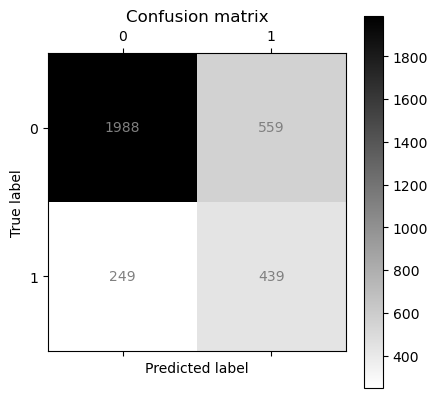

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      2547
           1       0.44      0.64      0.52       688

    accuracy                           0.75      3235
   macro avg       0.66      0.71      0.68      3235
weighted avg       0.79      0.75      0.77      3235



In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# save confusion matrix
cm = confusion_matrix(df["Biased"], df["Prediction_to_Boolean"])
plt.matshow(cm, cmap='binary')
plt.title('Confusion matrix')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='grey')

plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

import os
if not os.path.exists("../output/evaluation/mistral_prompt_5"):
    os.makedirs("../output/evaluation/mistral_prompt_5")
plt.savefig("../output/evaluation/mistral_prompt_5/confusion_matrix.png")

# save classification 
report = classification_report(df["Biased"], df["Prediction_to_Boolean"])
with open("../output/evaluation/mistral_prompt_5/classification_report.txt", "w") as file:
    file.write(report)

# show evaluation metrics
plt.show()
print(report)


# False Positives

Let's take a closer look at the errors.

In [20]:
mask = (df["Biased"] == 0) & (df["Prediction_to_Boolean"] == 1)
fp_df = df[mask]

pd.set_option('display.max_colwidth', None)

fp_df[["Biased", "Prediction_to_Boolean", "Text", "Prediction"]].tail()

,Biased,Prediction_to_Boolean,Text,Prediction
3171,0,1,"""I'm not antisemitic! That's just what the kikes want you to think!""",1 The tweet appears to be selfcontradicting with the user claiming that they are not antisemitic while using a historically antisemitic slur kikes This use of a term historically used to dehumanize and demonize Jews suggests that this statement is in fact an expression of hatred toward Jews Therefore according to the definition provided it could be considered as 1 Antisemitic
3172,0,1,"@benshapiro Hey Ben, if straight dudes can call gay people Queers, can I call Jews Kikes? like it's the same thing so its ok isn't it?",1 According to the definition of antisemitism provided and the content of the tweet this particular message is indeed antisemitic The tweet suggests that using a slur for Jewish people is equivalent to another word used by some individuals towards gay people thus normalizing hate speech against Jews This comparison of using derogatory language towards different groups is a form of dehumanization and demonization point 2 in the definition Moreover it clearly shows that the tweet user is intending to justify the use of a slur for Jewish people by claiming its the same as another slur used against another group This falls directly under the definition of antisemitism given particularly the points about dehumanization and demonization of Jews and the use of stereotypical or historical allegations
3190,0,1,@Ibutterfly34 @SamSlamDunkIAm @BernieSanders Another one called me a zionazi bitch they�re lovely,1 This tweet contains elements of antisemitism according to the definition provided specifically by using the term zionazi The combination of Zionist and Nazi implies that Jews are being compared to Nazis which falls under point 10 in the list of contemporary examples of antisemitism Furthermore calling someone a bitch after labeling them as a zionazi demonstrates hatred towards Jewish individuals or those perceived as Zionist So according to the provided definition this tweet can be classified as antisemitic
3218,0,1,"@LuanaGoriss @lokshensoupjek @McKayMSmith Oh yeah Forgot that one ""Zionazi"" The Jew haters adore that one ??",1 This tweet is antisemitic according to the definition provided as it uses a slur combining Zionist with Nazi Zionazi in reference to Jewish individuals or community Comparing Jews or Israel to Nazis falls under point 10 of the definition and is explicitly stated as an example of antisemitism Additionally this comparison is meant to insult and belittle Jewish people which also fits the description of antisemitic actions mentioned in the definition
3228,0,1,"@andywartrol @Keir_Starmer @standardnews @JewishChron Oh I do love waking up in the morning and being called a ""zionazi"". Go join Galloways SWGB and leave us Jewish Labour members alone.",1 The tweet does contain elements of antisemitism as it uses the term zionazi which is a slur that combines two historically persecuted groups Jews specifically Jewish Zionists and Nazis This term has no real meaning other than to insult and dehumanize its targetnn2 Moreover by suggesting that certain individuals should join Galloways SWP Socialist Workers Party it implies that these people are being driven out of the Labour Party a common antisemitic trope where Jews are perceived to have too much influence within any institutionnn3 Lastly referring to oneself as a Jewish Labour member can also be interpreted as a defensive or distancing move from accusations of antisemitism in the broader Labour party This can unintentionally reinforce the antisemitic narrative that Jews are somehow separate within the party and not representative of its entiretynnThe term zionazi coupled with the rest of the message is enough to classify this tweet as antisemitic according to the definition provided


# False Negatives

In [24]:
mask = (df["Biased"] == 1) & (df["Prediction_to_Boolean"] == 0)
fp_df = df[mask]

pd.set_option('display.max_colwidth', None)

fp_df[["Biased", "Prediction_to_Boolean", "Text", "Prediction"]].head(50)

,Biased,Prediction_to_Boolean,Text,Prediction
20,1,0,Israel more like isfake,0 The tweet does not contain any of the explicit or implicit references to Jews as a collective being responsible for wrongdoing nor does it demonize or dehumanize Jewish people It suggests that the existence of Israel is false but this statement can be considered as criticism towards the nationstate rather than antisemitic per se However its essential to consider the context in which such a comment is made as well as other tweets from the same user to ensure a comprehensive understanding before labeling something as antisemitic or not
33,1,0,@PLoyalties Israel is a blatant apartheid state committing Genocide on live stream video. While influencing the world with extreme wealth and perversely nefarious activities to repress any protest against them,0 This tweet although strongly critical of Israels policies and actions does not fall into the categories specified in the definition of antisemitism as it is focused on criticizing political and social issues within Israel rather than targeting Jews or Judaism While some statements may be seen as exaggerated they do not qualify as demonizing or dehumanizing Jewish individuals nor are they suggesting that all Jews should be held responsible for the actions of Israel The tweet is primarily about criticizing the countrys policies and does not meet the criteria specified in the antisemitism definition provided
53,1,0,@LilGuillxtine @scottbix @yashar Thats Israel hating Palestine supporting money hating Jewishness for you.\nCalling him Jew is like calling Rushdie Muslim.,0 This tweet is not antisemitic according to the provided definition of antisemitism While it may express criticism towards Israel and its actions it does not contain any hateful language or dehumanizing stereotypes directed towards Jews or Jewishness as a whole Instead the tweet compares someones stance on an issue to being equivalent to calling Rushdie Muslim which is more of a commentary on the comparison rather than an expression of antisemitism The mention of Jewishness does not imply any harmful intent towards Jews or their beliefs but merely refers to the subject matter at hand
65,1,0,@sunlorrie Israel is an apartheid racist state.,0nnThe provided tweet states sunlorrie Israel is an apartheid racist state While this statement may criticize the government of Israel and its policies it does not necessarily fall under any specific category of antisemitism as defined Antisemitism often targets Jewish individuals or communities with hatred stereotyping or conspiracy theories while this tweet is solely focused on the Israeli states politics and policies While some people may argue that criticism of Israel is inherently antisemitic due to the concept of collective guilt point 11 in your definition it does not directly meet any of the ten categories mentioned in your provided definition of antisemitism Its crucial to note that not every criticism of Israel necessarily constitutes antisemitism as the definition also specifies that Criticism of Israel similar to that leveled against any other country cannot be regarded as antisemitic Thus according to this definition this specific tweet should not be considered antisemitic
71,1,0,"As Israel moves forward with the annexation of the West Bank, and mainstream British politics is gagged of the right to critique Zionism, and Israel’s settler colonial pursuits, we loudly and clearly stand beside our Palestinian comrades. \n\nFREE PALESTINE.",0 This tweet criticizes Israels annexation of the West Bank and its relationship with British politics regarding Zionism without making any dehumanizing or stereotypical allegations about Jews or using antisemitic tropes It also expresses solidarity with Palestinians but does not fit within any of the criteria outlined for contemporary examples of antisemitism in the definition provided
72,1,0,"@JWood99189387 @jeremycorbyn Israel where there is the worst apartheid, 